
# Proyecto. Aplicacion de Redes Neuronales

Hernandez Martinez Mally Samira | Código: 220286113 | Ingenieria de computacion (INCO) 

Seminario de Solucion de Problemas de Inteligencia Artificial II | Seccion D05 I7041


<u>Caso de estudio</u>:

Implementación de un clasificador automático de señales de ECG para la detección de arritmias, utilizando la base de datos MIT-BIH. Este sistema está diseñado para identificar automáticamente distintos tipos de arritmias, como el ritmo sinusal normal, contracciones ventriculares prematuras, y otras anomalías del ritmo cardíaco. Su aplicación potencial incluye su uso en sistemas de monitoreo médico en tiempo real para hospitales y dispositivos de telemedicina, permitiendo a los profesionales de la salud realizar un diagnóstico temprano y personalizado. Además, al facilitar una clasificación precisa y rápida, este sistema puede mejorar la accesibilidad a la atención médica remota, optimizando la capacidad de respuesta ante emergencias cardíacas y elevando el nivel de atención para pacientes con enfermedades cardiovasculares.

In [ ]:
# Importacion de librerías
import os
import sys
import time
import random
import sklearn
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.io as pio
import tensorflow as tf
import matplotlib.cm as cm
import plotly.express as px
import matplotlib.pyplot as plt
from keras.regularizers import l2
from keras.applications import VGG16 
from keras.preprocessing import image
from keras.utils import load_img, img_to_array 
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Conv1D, LSTM, MaxPooling1D, Input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, EarlyStopping
from keras.applications.vgg16 import preprocess_input, decode_predictions 
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from scipy.signal import resample, butter, filtfilt
from PIL import UnidentifiedImageError 
from contextlib import contextmanager
from IPython.display import display
from keras.optimizers import Adam 
from tensorflow import keras
from PIL import ImageFile
from PIL import Image

1.	Preprocesamiento de Datos:

    - Cargar el conjunto de datos de ECG de la base MIT-BIH, que incluye múltiples clases de arritmias (por ejemplo, ritmo sinusal normal, contracción ventricular prematura, entre otros).

    - Asegurarse de que las señales estén correctamente etiquetadas para los distintos tipos de arritmias.

    - Estandarizar la longitud de las señales para que todas tengan el mismo tamaño o segmentar cada muestra de ECG en ventanas de longitud fija, adecuadas para el modelo.

    - Normalizar los datos de entrada para mejorar la convergencia del modelo, escalando los valores de las señales dentro de un rango adecuado.


In [3]:
# Función para cargar y preprocesar los datos
def cargar_y_preprocesar(ruta_datos, archivo):
    ruta_archivo = os.path.join(ruta_datos, archivo)
    if not os.path.exists(ruta_archivo):                                    # Verificar si el archivo existe
        raise FileNotFoundError(f"El archivo {ruta_archivo} no existe.")
    data = pd.read_csv(ruta_archivo, header=None)                           # Cargar datos (tabla)
    print(f"Datos cargados correctamente desde {ruta_archivo}.")
    print(f"Dimensiones de los datos: {data.shape}")                        # Mostrar tamaño de los datos
    print("------------------------------------------------------------")
    display(data.head())                                                    # Mostrar las primeras filas de los datos
    print("Revisando valores faltantes...")                                 # Inspeccionar valores faltantes
    print(data.isna().sum())                                                # Conteo de valores NaN por columna
    X = data.iloc[:, :187].values                                           # Separar características y etiquetas
    y = data.iloc[:, 187].values
    print(f"Características (X) y etiquetas (y) separadas: X.shape = {X.shape}, y.shape = {y.shape}.")   
    print("--------------------------------------------------------------------------------------------------------------------------------------------------------")
    return X, y

ruta_datos = 'MIT-BIH/'                                                     # Ruta del conjunto de datos
train_file = 'mitbih_train.csv'                                             # Archivos de datos
test_file = 'mitbih_test.csv'

X_train, y_train = cargar_y_preprocesar(ruta_datos, train_file)             # Cargar datos de entrenamiento y prueba con estandarización
X_test, y_test = cargar_y_preprocesar(ruta_datos, test_file)

Datos cargados correctamente desde MIT-BIH/mitbih_train.csv.
Dimensiones de los datos: (87554, 188)
------------------------------------------------------------


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Revisando valores faltantes...
0      0
1      0
2      0
3      0
4      0
      ..
183    0
184    0
185    0
186    0
187    0
Length: 188, dtype: int64
Características (X) y etiquetas (y) separadas: X.shape = (87554, 187), y.shape = (87554,).
--------------------------------------------------------------------------------------------------------------------------------------------------------
Datos cargados correctamente desde MIT-BIH/mitbih_test.csv.
Dimensiones de los datos: (21892, 188)
------------------------------------------------------------


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Revisando valores faltantes...
0      0
1      0
2      0
3      0
4      0
      ..
183    0
184    0
185    0
186    0
187    0
Length: 188, dtype: int64
Características (X) y etiquetas (y) separadas: X.shape = (21892, 187), y.shape = (21892,).
--------------------------------------------------------------------------------------------------------------------------------------------------------


In [4]:
# Diccionario de etiquetas
labels = {
    0: "Normal",
    1: "Prematura Auricular",
    2: "Contracción Ventricular Prematura",
    3: "Fusión de Ventricular y Normal",
    4: "Fusión de Estimulación y Normal"
}

# Conteo de etiquetas en el conjunto de entrenamiento
value_counts_train = pd.Series(y_train).value_counts().sort_index()         # Obtener conteo de cada clase
value_counts_train.index = value_counts_train.index.map(labels)             # Renombrar índices con etiquetas legibles

# Crear gráfica de pastel
pie_fig = px.pie(
    names=value_counts_train.index,
    values=value_counts_train.values,
    title="Porcentaje de Cada Etiqueta en el Conjunto de Entrenamiento"
)

pie_fig.update_layout(title_x=0.5, width=800, height=600)                   # Configuración de diseño

print("Distribución en el conjunto de entrenamiento")                       
print("---------------------------------------------")                      
print(pd.Series(y_train).value_counts().sort_index())
print("---------------------------------------------") 
pie_fig.show()                                                              # Mostrar gráfica

Distribución en el conjunto de entrenamiento
---------------------------------------------
0.0    72471
1.0     2223
2.0     5788
3.0      641
4.0     6431
Name: count, dtype: int64
---------------------------------------------


In [4]:
# Conteo de etiquetas en el conjunto de prueba
value_counts_test = pd.Series(y_test).value_counts().sort_index()           # Obtener conteo de cada clase
value_counts_test.index = value_counts_test.index.map(labels)               # Renombrar índices con etiquetas legibles

# Crear gráfica de pastel para el conjunto de prueba
pie_fig_test = px.pie(
    names=value_counts_test.index,
    values=value_counts_test.values,
    title="Porcentaje de Cada Etiqueta en el Conjunto de Prueba"
)

pie_fig_test.update_layout(title_x=0.5, width=800, height=600)              # Configuración de diseño

print("\nDistribución en el conjunto de prueba")
print("---------------------------------------------") 
print(pd.Series(y_test).value_counts().sort_index())
print("---------------------------------------------") 
pie_fig_test.show()                                                         # Mostrar gráfica


Distribución en el conjunto de prueba
---------------------------------------------
0.0    18118
1.0      556
2.0     1448
3.0      162
4.0     1608
Name: count, dtype: int64
---------------------------------------------


In [5]:
train_data = pd.read_csv('MIT-BIH/mitbih_train.csv', header=None)           # Cargar datos desde el archivo CSV

# Extraer señales representativas usando los parámetros actuales
ecg_0 = train_data.loc[train_data[187] == 0, :].iloc[1, :187]               
ecg_1 = train_data.loc[train_data[187] == 1, :].iloc[1, :187]               
ecg_2 = train_data.loc[train_data[187] == 2, :].iloc[1, :187]              
ecg_3 = train_data.loc[train_data[187] == 3, :].iloc[1, :187]               
ecg_4 = train_data.loc[train_data[187] == 4, :].iloc[1, :187]               

# Crear un DataFrame con las señales
ecg_df = pd.DataFrame({
    'Normal': ecg_0,
    'Prematura Auricular': ecg_1,
    'Contracción Ventricular Prematura': ecg_2,
    'Fusión de Ventricular y Normal': ecg_3,
    'Fusión de Estimulación y Normal': ecg_4
})

# Graficar con Plotly
ecg_plot = px.line(
    ecg_df,
    labels={'index': 'Intervalos de Tiempo', 'value': 'Amplitud (mV)', 'variable': 'Categorías'},
    title="Una Señal ECG de Cada Categoría"
)

ecg_plot.update_layout(title_x=0.25, width=1000, height=500)                # Configurar diseño de la gráfica

ecg_plot.show()                                                             # Mostrar gráfica

In [6]:
test_data = pd.read_csv('MIT-BIH/mitbih_test.csv', header=None)           # Cargar datos desde el archivo CSV

# Extraer señales representativas usando los parámetros actuales para el conjunto de prueba
ecg_0_test = test_data.loc[test_data[187] == 0, :].iloc[1, :187]  
ecg_1_test = test_data.loc[test_data[187] == 1, :].iloc[1, :187]  
ecg_2_test = test_data.loc[test_data[187] == 2, :].iloc[1, :187]  
ecg_3_test = test_data.loc[test_data[187] == 3, :].iloc[1, :187]  
ecg_4_test = test_data.loc[test_data[187] == 4, :].iloc[1, :187]  

# Crear un DataFrame con las señales del conjunto de prueba
ecg_df_test = pd.DataFrame({
    'Normal': ecg_0_test,
    'Prematura Auricular': ecg_1_test,
    'Contracción Ventricular Prematura': ecg_2_test,
    'Fusión de Ventricular y Normal': ecg_3_test,
    'Fusión de Estimulación y Normal': ecg_4_test
})

# Graficar con Plotly para el conjunto de prueba
ecg_plot_test = px.line(
    ecg_df_test,
    labels={'index': 'Intervalos de Tiempo', 'value': 'Amplitud (mV)', 'variable': 'Categorías'},
    title="Una Señal ECG de Cada Categoría en el Conjunto de Prueba"
)

ecg_plot_test.update_layout(title_x=0.25, width=1000, height=500)       # Configurar diseño de la gráfica

ecg_plot_test.show()                                                    # Mostrar gráfica


In [7]:
# Separar características y etiquetas
data = train_data.iloc[:, :187]                                         # Columnas de características (señales)
labels = train_data.iloc[:, 187]                                        # Última columna como etiquetas

# Balancear las clases con RandomOverSampler
print("Balanceando las clases con RandomOverSampler...")
ros = RandomOverSampler(random_state=42)
data_resampled, labels_resampled = ros.fit_resample(data, labels)
print(f"Dimensiones después del balanceo: {data_resampled.shape}")

# Combinar las características y etiquetas balanceadas
train_df = pd.concat([pd.DataFrame(data_resampled), pd.DataFrame(labels_resampled)], axis=1)
train_df.columns = list(range(train_df.shape[1]))                       # Asignar columnas con índices consecutivos

print(f"Nuevo tamaño del conjunto de datos balanceado: {train_df.shape}")

Balanceando las clases con RandomOverSampler...
Dimensiones después del balanceo: (362355, 187)
Nuevo tamaño del conjunto de datos balanceado: (362355, 188)


In [8]:
# Diccionario para mapear las clases numéricas a nombres descriptivos
classes = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}

value_counts = train_df.iloc[:, -1].value_counts().rename(classes)      # Contar la cantidad de muestras por clase y renombrar con etiquetas descriptivas

# Crear una gráfica de pastel para visualizar la distribución de clases balanceadas
pie_fig = px.pie(
    names=value_counts.index,                                           # Nombres de las clases
    values=value_counts.values,                                         # Cantidad de muestras por clase
    title="The Percentage of Each Label After Balancing"                # Título de la gráfica
)

pie_fig.update_layout(title_x=0.5, width=800, height=600)               # Configurar y mostrar la gráfica
pie_fig.show()                                                          # Mostrar gráfica


In [9]:
# Función para estandarizar la longitud de las señales
def estandarizar_longitud(señales, longitud_objetivo=187):
    señales_estandarizadas = [resample(señal, longitud_objetivo) for señal in señales]
    return np.array(señales_estandarizadas)

# Separar características y etiquetas del DataFrame balanceado
data = train_df.iloc[:, :187].values                                     # Señales (características)
labels = train_df.iloc[:, 187].values                                    # Etiquetas

print("Iniciando preprocesamiento de señales...")                       # Estandarizar la longitud de las señales
longitud_objetivo = 187                                                 # Definir longitud fija para las señales
data_estandarizada = estandarizar_longitud(data, longitud_objetivo)
print(f"Señales estandarizadas: {data_estandarizada.shape} (Longitud fija: {longitud_objetivo})")

Iniciando preprocesamiento de señales...
Señales estandarizadas: (362355, 187) (Longitud fija: 187)


In [10]:
# Normalizar las señales
print("Normalizando las señales...")
scaler = MinMaxScaler(feature_range=(0, 1))                             # Normalización en rango [0, 1]
data_normalizada = scaler.fit_transform(data_estandarizada)
print(f"Señales normalizadas: {data_normalizada.shape} (Rango: 0 a 1)")

print("Preprocesamiento completado. Los datos están listos para el modelo.")
print(f"Tamaño final de las señales: {data_normalizada.shape}")
print(f"Cantidad de etiquetas: {len(labels)}")

# normalizar X_train y X_test adicionalmente                            # normalizar X_train y X_test adicionalmente
print("\nNormalizando datos de entrenamiento y prueba...")
X_train_normalized = scaler.fit_transform(X_train)                      # Normalización de entrenamiento
X_test_normalized = scaler.transform(X_test)                            # Normalización de prueba

print("completado. Los datos están listos para el modelo.")
print("-------------------------------------------------------------------")
print(f"Datos de entrenamiento normalizados: {X_train_normalized.shape}")
print(f"Datos de prueba normalizados: {X_test_normalized.shape}")


Normalizando las señales...
Señales normalizadas: (362355, 187) (Rango: 0 a 1)
Preprocesamiento completado. Los datos están listos para el modelo.
Tamaño final de las señales: (362355, 187)
Cantidad de etiquetas: 362355

Normalizando datos de entrenamiento y prueba...
completado. Los datos están listos para el modelo.
-------------------------------------------------------------------
Datos de entrenamiento normalizados: (87554, 187)
Datos de prueba normalizados: (21892, 187)


In [19]:
x = train_df.iloc[:,:187]                                               # Separar características y etiquetas de train_df
y = train_df.iloc[:,187]
x_test = test_data.iloc[:,:187]                                         # Separar características y etiquetas del conjunto de prueba
y_test = test_data.iloc[: ,187]

# Dividir train_df en conjunto de entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Tamaño del conjunto de entrenamiento: {x_train.shape}")         # Imprimir las dimensiones de los conjuntos resultantes
print(f"Tamaño del conjunto de validación: {x_val.shape}")
print(f"Tamaño del conjunto de prueba: {x_test.shape}")

x_train = x_train.values.reshape(x_train.shape[0], -1, 1)               # Cambiar la forma de los datos para que sean compatibles con CNN
x_val = x_val.values.reshape(x_val.shape[0], -1, 1)
x_test = x_test.values.reshape(x_test.shape[0], -1, 1)

y_train = tf.keras.utils.to_categorical(y_train)                        # Convertir las etiquetas a formato one-hot encoding
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)
print("---------------------------------------------------------")
print('x_train shape: ', x_train.shape)                                 # Verificar las dimensiones de los conjuntos después del preprocesamiento
print('y_train shape: ', y_train.shape)
print('x_val shape: ', x_val.shape)
print('y_val shape: ', y_val.shape)
print('x_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)
print("---------------------------------------------------------")

Tamaño del conjunto de entrenamiento: (289884, 187)
Tamaño del conjunto de validación: (72471, 187)
Tamaño del conjunto de prueba: (21892, 187)
---------------------------------------------------------
x_train shape:  (289884, 187, 1)
y_train shape:  (289884, 5)
x_val shape:  (72471, 187, 1)
y_val shape:  (72471, 5)
x_test shape:  (21892, 187, 1)
y_test shape:  (21892, 5)
---------------------------------------------------------


2.	Definición del Modelo:

        a) Prueba 1: Modelo ANN (Red Neuronal Artificial)

    - Implementar una red neuronal completamente conectada con varias capas densas para extraer características básicas de las señales de ECG.

    - Seleccionar la cantidad de neuronas en cada capa y usar funciones de activación ReLU para las capas intermedias.

    - Agregar capas de Dropout para reducir el sobreajuste.

    - La capa de salida debe tener tantas neuronas como clases de arritmias, usando una función de activación softmax.

    - Compilar el modelo utilizando un optimizador como Adam y la función de pérdida categorical_crossentropy.

3.	Ajuste de Hiperparámetros y Fine-tuning:

    - Para cada modelo (ANN, CNN, RNN), ajustar el número de capas, unidades filtros por capa, tasa de aprendizaje y épocas de entrenamiento hasta obtener buenos resultados en términos de precisión.

     - En el caso de la RNN, ajustar el tamaño de la ventana temporal para captar mejor las características temporales de la señal.

In [20]:
 #Definir el modelo ANN
def crear_modelo_ann(input_dim, num_clases):
    modelo = Sequential()
    
    # Capa de entrada y primera capa oculta
    modelo.add(Dense(128, activation='relu', input_dim=input_dim))          
    modelo.add(Dropout(0.3))                                                # Dropout para reducir el sobreajuste
    
    # Segunda capa oculta
    modelo.add(Dense(64, activation='relu'))
    modelo.add(Dropout(0.3))
    
    # Capa de salida
    modelo.add(Dense(num_clases, activation='softmax'))                     # Softmax para clasificación multiclase
    
    # Compilar el modelo
    modelo.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return modelo

# Crear modelo ANN
input_dim = x_train.shape[1]                                                # Número de características de entrada
num_clases = y_train.shape[1]                                               # Número de clases en formato One-Hot Encoding
modelo_ann = crear_modelo_ann(input_dim, num_clases)

modelo_ann.summary()                                                        # Mostrar resumen del modelo

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               24064     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 32645 (127.52 KB)
Trainable params: 32645 (127.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
# Cargar el modelo desde el checkpoint existente
model_path = 'modelo_ann_checkpoint.h5'
if os.path.exists(model_path):
    print("--------------------------------------------")
    print(" Cargando el modelo desde el checkpoint...")
    print("--------------------------------------------")
    modelo_ann = tf.keras.models.load_model(model_path)
else:
    raise FileNotFoundError(f"El checkpoint '{model_path}' no existe. Por favor, asegúrate de haber guardado el modelo previamente.")

# Guardar el mejor modelo
checkpoint = ModelCheckpoint( filepath='modelo_ann_checkpoint.h5', save_best_only=True, monitor='val_loss', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo
history = modelo_ann.fit(
    x_train, y_train,                                                       # Datos de entrenamiento
    validation_data=(x_val, y_val),                                         # Datos de validación
    epochs=20,
    batch_size=64,
    callbacks=[checkpoint, early_stopping]
)

# Evaluar el modelo con el conjunto de prueba
print("-------------------------------------------------------------------")
print("Cargando el mejor modelo desde el checkpoint...")
modelo_ann = tf.keras.models.load_model('modelo_ann_checkpoint.h5')
loss, accuracy = modelo_ann.evaluate(x_test, y_test)
print("-------------------------------------------------------------------")
print(f" Pérdida en prueba: {loss:.4f}")
print(f" Precisión en prueba: {accuracy:.4f}")
print("-------------------------------------------------------------------")

--------------------------------------------
 Cargando el modelo desde el checkpoint...
--------------------------------------------
Epoch 1/20
4522/4530 [============================>.] - ETA: 0s - loss: 0.1051 - accuracy: 0.9630
Epoch 1: val_loss improved from inf to 0.05460, saving model to modelo_ann_checkpoint.h5
4530/4530 [==============================] - 18s 4ms/step - loss: 0.1051 - accuracy: 0.9630 - val_loss: 0.0546 - val_accuracy: 0.9822
Epoch 2/20
4529/4530 [============================>.] - ETA: 0s - loss: 0.1052 - accuracy: 0.9633
Epoch 2: val_loss improved from 0.05460 to 0.05259, saving model to modelo_ann_checkpoint.h5
4530/4530 [==============================] - 17s 4ms/step - loss: 0.1052 - accuracy: 0.9633 - val_loss: 0.0526 - val_accuracy: 0.9831
Epoch 3/20
4526/4530 [============================>.] - ETA: 0s - loss: 0.1025 - accuracy: 0.9639
Epoch 3: val_loss did not improve from 0.05259
4530/4530 [==============================] - 17s 4ms/step - loss: 0.1026 - a

4.	Evaluación y Métricas:

    -	Evaluar el desempeño de cada modelo en el conjunto de validación utilizando métricas como precisión, recall, F1-score y pérdida.

    -	Generar y analizar la matriz de confusión para observar la precisión de cada clase de arritmia.

    -	Graficar la evolución de la precisión y la pérdida durante el entrenamiento y la validación para cada modelo.

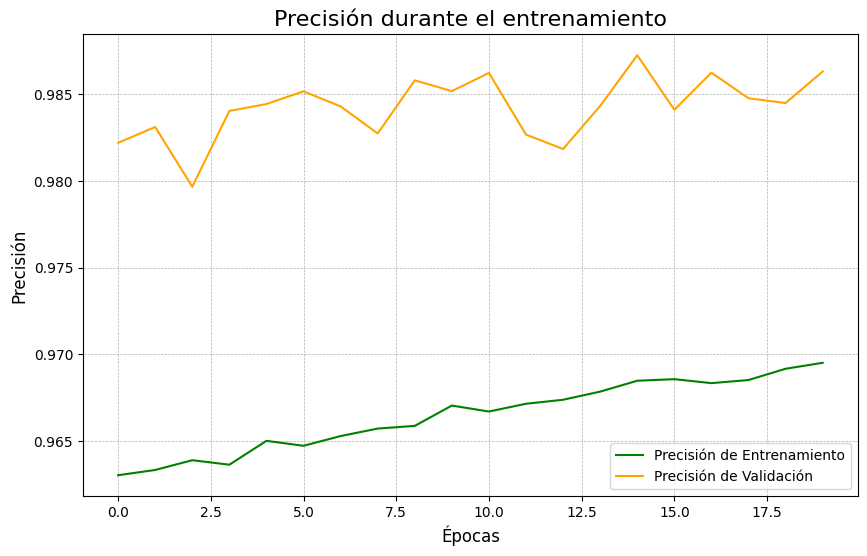

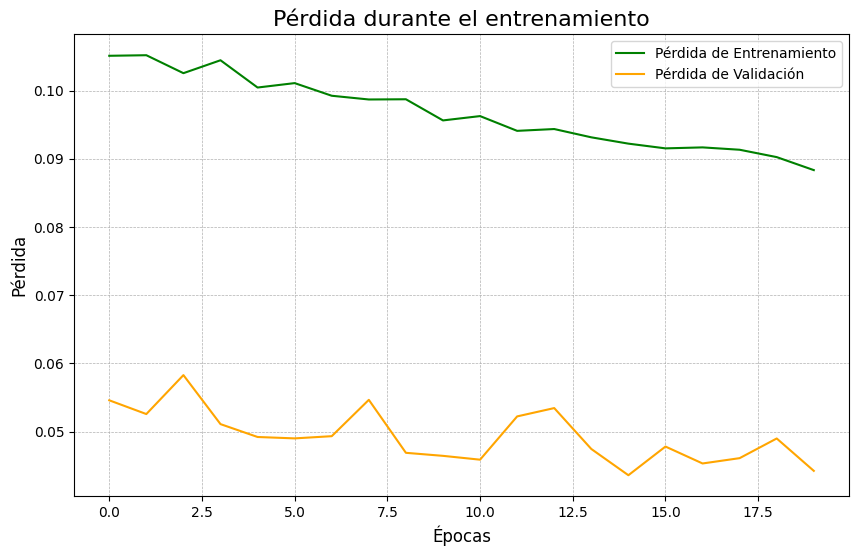

In [45]:
def plot_metrics_custom(history):
    # Crear una figura para precisión
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], color='green', label='Precisión de Entrenamiento')
    plt.plot(history.history['val_accuracy'], color='orange', label='Precisión de Validación')
    plt.title('Precisión durante el entrenamiento', fontsize=16)
    plt.xlabel('Épocas', fontsize=12)
    plt.ylabel('Precisión', fontsize=12)
    plt.legend(loc='lower right')
    plt.grid(visible=True, linestyle='--', linewidth=0.5)
    plt.show()

    # Crear una figura para pérdida
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], color='green', label='Pérdida de Entrenamiento')
    plt.plot(history.history['val_loss'], color='orange', label='Pérdida de Validación')
    plt.title('Pérdida durante el entrenamiento', fontsize=16)
    plt.xlabel('Épocas', fontsize=12)
    plt.ylabel('Pérdida', fontsize=12)
    plt.legend(loc='upper right')
    plt.grid(visible=True, linestyle='--', linewidth=0.5)
    plt.show()

plot_metrics_custom(history)                                                # Llamar a la función para graficar

In [46]:
# Generar predicciones para el conjunto de prueba con ANN
y_pred_ann = modelo_ann.predict(x_test)
y_pred_classes_ann = np.argmax(y_pred_ann, axis=1)                          # Convertir probabilidades a clases
y_true_classes_ann = np.argmax(y_test, axis=1)                              # Etiquetas reales en formato one-hot

conf_matrix_ann = confusion_matrix(y_true_classes_ann, y_pred_classes_ann)  # Crear la matriz de confusión para ANN

# Calcular métricas de evaluación para ANN
report_ann = classification_report(
    y_true_classes_ann,
    y_pred_classes_ann,
    target_names=[f"Clase {i}" for i in range(y_test.shape[1])]
)
print("--------------------------------------------------------")
print(" Reporte de Clasificación para ANN")
print("--------------------------------------------------------")
print(report_ann)
print("--------------------------------------------------------")

685/685 [==============================] - 1s 2ms/step
--------------------------------------------------------
 Reporte de Clasificación para ANN
--------------------------------------------------------
              precision    recall  f1-score   support

     Clase 0       0.99      0.95      0.97     18118
     Clase 1       0.49      0.83      0.62       556
     Clase 2       0.85      0.96      0.90      1448
     Clase 3       0.49      0.85      0.62       162
     Clase 4       0.97      0.98      0.97      1608

    accuracy                           0.95     21892
   macro avg       0.76      0.91      0.82     21892
weighted avg       0.96      0.95      0.96     21892

--------------------------------------------------------


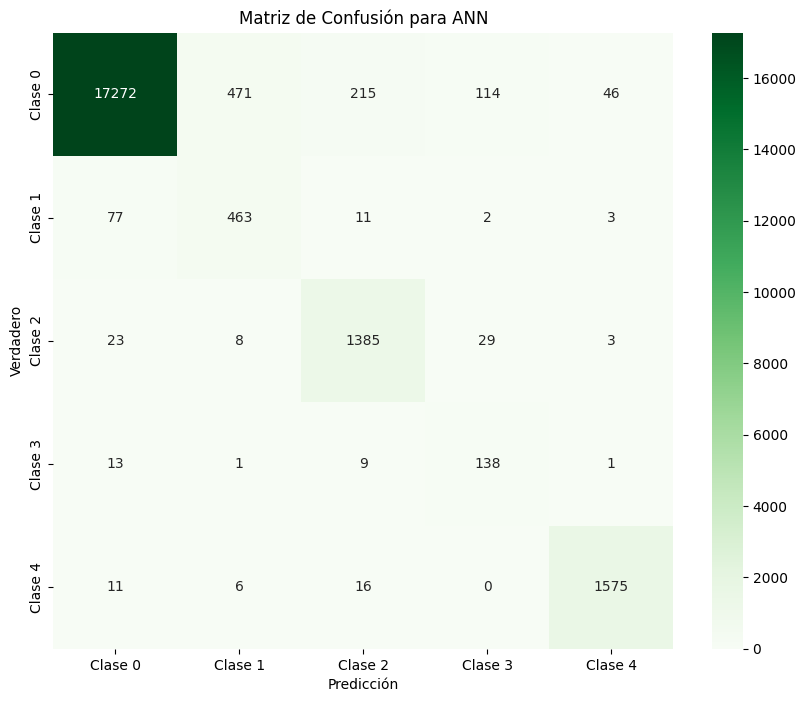

In [47]:
# Graficar la matriz de confusión para ANN con tonos verdes
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix_ann, 
    annot=True, 
    fmt="d", 
    cmap="Greens",  # Cambia el mapa de colores a 'Greens'
    xticklabels=[f"Clase {i}" for i in range(y_test.shape[1])],
    yticklabels=[f"Clase {i}" for i in range(y_test.shape[1])]
)
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión para ANN")
plt.show()


2.	Definición del Modelo:

        b) Prueba 2: Modelo CNN (Red Neuronal Convolucional)

    - Implementar una CNN con capas convolucionales para extraer características espaciales de las señales.   

    - Las capas convolucionales deben incluir filtros de distintas profundidades (por ejemplo, 32, 64, 128), con funciones de activación ReLU.

    - Usar capas de Batch Normalization para estabilizar el entrenamiento y mejorar la generalización.

    - Agregar capas de MaxPooling para reducir la dimensionalidad.

    - Incluir capas Dropout para evitar el sobreajuste.

    - La capa de salida debe tener tantas neuronas como clases de arritmias, usando una función de activación softmax.

In [48]:
# Definir el modelo CNN
def crear_modelo_cnn(input_shape, num_clases):
    modelo = Sequential()

    # Primera capa convolucional
    modelo.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    modelo.add(BatchNormalization())                                        # Batch Normalization
    modelo.add(MaxPooling1D(pool_size=2))                                   # MaxPooling para reducir dimensionalidad
    modelo.add(Dropout(0.3))                                                # Dropout para evitar sobreajuste

    # Segunda capa convolucional
    modelo.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    modelo.add(BatchNormalization())
    modelo.add(MaxPooling1D(pool_size=2))
    modelo.add(Dropout(0.3))

    # Tercera capa convolucional
    modelo.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    modelo.add(BatchNormalization())
    modelo.add(MaxPooling1D(pool_size=2))
    modelo.add(Dropout(0.4))

    # Capa completamente conectada
    modelo.add(Flatten())                                                   # Aplanar la salida de las capas convolucionales
    modelo.add(Dense(128, activation='relu'))                               # Capa densa intermedia
    modelo.add(Dropout(0.4))                                                # Dropout adicional

    # Capa de salida
    modelo.add(Dense(num_clases, activation='softmax'))                     # Softmax para clasificación multiclase

    # Compilar el modelo
    modelo.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return modelo

# Crear el modelo CNN
input_shape = x_train.shape[1:]                                             # Forma de entrada (señales ya preprocesadas y normalizadas)
num_clases = y_train.shape[1]                                               # Número de clases en formato One-Hot Encoding
modelo_cnn = crear_modelo_cnn(input_shape, num_clases)

modelo_cnn.summary()                                                        # Mostrar resumen del modelo

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 185, 32)           128       
                                                                 
 batch_normalization_15 (Ba  (None, 185, 32)           128       
 tchNormalization)                                               
                                                                 
 max_pooling1d_15 (MaxPooli  (None, 92, 32)            0         
 ng1D)                                                           
                                                                 
 dropout_22 (Dropout)        (None, 92, 32)            0         
                                                                 
 conv1d_16 (Conv1D)          (None, 90, 64)            6208      
                                                                 
 batch_normalization_16 (Ba  (None, 90, 64)           

In [50]:
# Cargar el modelo desde el checkpoint existente
model_path = 'modelo_cnn_checkpoint.h5'
if os.path.exists(model_path):
    print("--------------------------------------------")
    print(" Cargando el modelo desde el checkpoint...")
    print("--------------------------------------------")
    modelo_cnn = tf.keras.models.load_model(model_path)
else:
    raise FileNotFoundError(f"El checkpoint '{model_path}' no existe. Por favor, asegúrate de haber guardado el modelo previamente.")

# Guardar el mejor modelo
checkpoint = ModelCheckpoint(filepath='modelo_cnn_checkpoint.h5', save_best_only=True, monitor='val_loss', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo
history_cnn = modelo_cnn.fit(
    x_train, y_train,                                                       # Datos de entrenamiento
    validation_data=(x_val, y_val),                                         # Datos de validación
    epochs=20,
    batch_size=64,
    callbacks=[checkpoint, early_stopping]
)

# Evaluar el modelo con el conjunto de prueba
print("-------------------------------------------------------------------")
print(" Cargando el mejor modelo desde el checkpoint...")
modelo_cnn = tf.keras.models.load_model('modelo_cnn_checkpoint.h5')
print("-------------------------------------------------------------------")
loss, accuracy = modelo_cnn.evaluate(x_test, y_test)
print(f" Pérdida en prueba: {loss:.4f}")
print(f" Precisión en prueba: {accuracy:.4f}")
print("-------------------------------------------------------------------")

--------------------------------------------
 Cargando el modelo desde el checkpoint...
--------------------------------------------
Epoch 1/20
4529/4530 [============================>.] - ETA: 0s - loss: 0.0547 - accuracy: 0.9811
Epoch 1: val_loss improved from inf to 0.02303, saving model to modelo_cnn_checkpoint.h5
4530/4530 [==============================] - 276s 61ms/step - loss: 0.0547 - accuracy: 0.9811 - val_loss: 0.0230 - val_accuracy: 0.9930
Epoch 2/20
4529/4530 [============================>.] - ETA: 0s - loss: 0.0542 - accuracy: 0.9817
Epoch 2: val_loss improved from 0.02303 to 0.02240, saving model to modelo_cnn_checkpoint.h5
4530/4530 [==============================] - 300s 66ms/step - loss: 0.0542 - accuracy: 0.9817 - val_loss: 0.0224 - val_accuracy: 0.9930
Epoch 3/20
4529/4530 [============================>.] - ETA: 0s - loss: 0.0530 - accuracy: 0.9817
Epoch 3: val_loss improved from 0.02240 to 0.01850, saving model to modelo_cnn_checkpoint.h5
4530/4530 [===============

4.	Evaluación y Métricas:

    -	Evaluar el desempeño de cada modelo en el conjunto de validación utilizando métricas como precisión, recall, F1-score y pérdida.

    -	Generar y analizar la matriz de confusión para observar la precisión de cada clase de arritmia.

    -	Graficar la evolución de la precisión y la pérdida durante el entrenamiento y la validación para cada modelo.

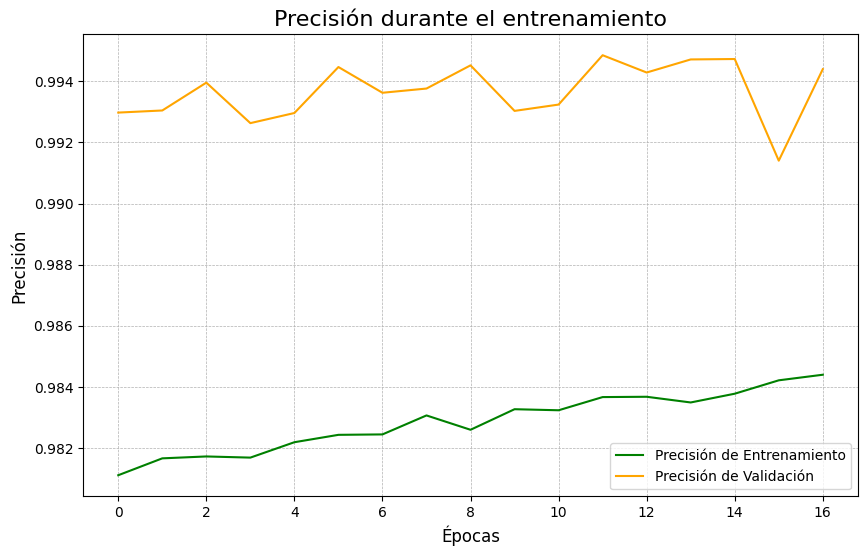

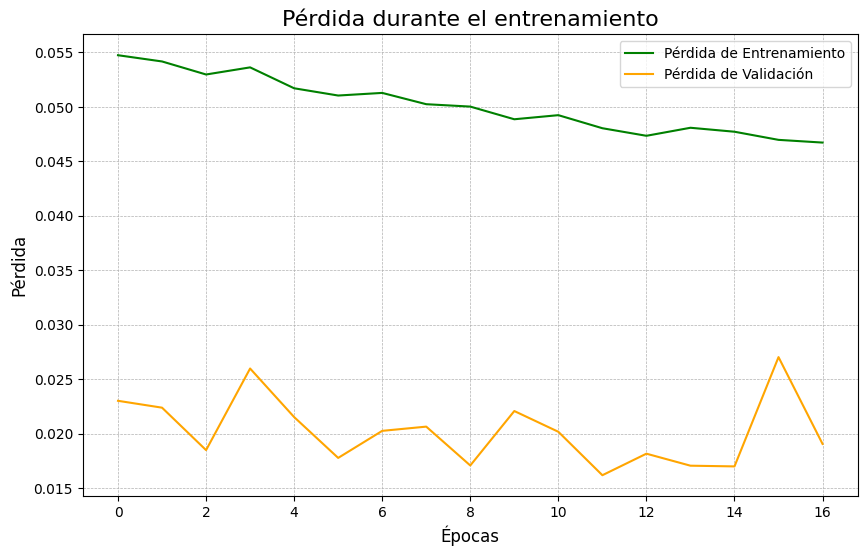

In [52]:
def plot_metrics_custom(history):
    # Crear una figura para precisión
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], color='green', label='Precisión de Entrenamiento')
    plt.plot(history.history['val_accuracy'], color='orange', label='Precisión de Validación')
    plt.title('Precisión durante el entrenamiento', fontsize=16)
    plt.xlabel('Épocas', fontsize=12)
    plt.ylabel('Precisión', fontsize=12)
    plt.legend(loc='lower right')
    plt.grid(visible=True, linestyle='--', linewidth=0.5)
    plt.show()

    # Crear una figura para pérdida
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], color='green', label='Pérdida de Entrenamiento')
    plt.plot(history.history['val_loss'], color='orange', label='Pérdida de Validación')
    plt.title('Pérdida durante el entrenamiento', fontsize=16)
    plt.xlabel('Épocas', fontsize=12)
    plt.ylabel('Pérdida', fontsize=12)
    plt.legend(loc='upper right')
    plt.grid(visible=True, linestyle='--', linewidth=0.5)
    plt.show()

plot_metrics_custom(history_cnn)         


In [54]:
# Generar predicciones para el conjunto de prueba con ANN
y_pred_cnn = modelo_cnn.predict(x_test)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)                          # Convertir probabilidades a clases
y_true_classes_cnn = np.argmax(y_test, axis=1)                              # Etiquetas reales en formato one-hot

conf_matrix_cnn = confusion_matrix(y_true_classes_cnn, y_pred_classes_cnn)  # Crear la matriz de confusión para ANN

# Calcular métricas de evaluación para ANN
report_cnn = classification_report(
    y_true_classes_cnn,
    y_pred_classes_cnn,
    target_names=[f"Clase {i}" for i in range(y_test.shape[1])]
)
print("--------------------------------------------------------")
print(" Reporte de Clasificación para CNN")
print("--------------------------------------------------------")
print(report_cnn)
print("--------------------------------------------------------")

685/685 [==============================] - 4s 6ms/step
--------------------------------------------------------
 Reporte de Clasificación para CNN
--------------------------------------------------------
              precision    recall  f1-score   support

     Clase 0       0.99      0.98      0.99     18118
     Clase 1       0.73      0.88      0.80       556
     Clase 2       0.95      0.96      0.96      1448
     Clase 3       0.43      0.86      0.58       162
     Clase 4       0.99      0.99      0.99      1608

    accuracy                           0.98     21892
   macro avg       0.82      0.93      0.86     21892
weighted avg       0.98      0.98      0.98     21892

--------------------------------------------------------


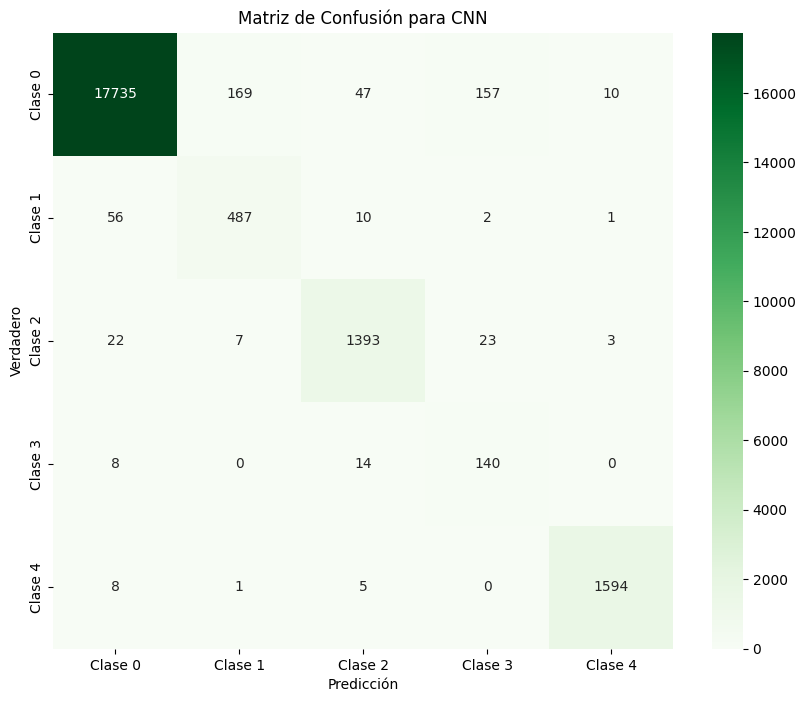

In [56]:
# Graficar la matriz de confusión para ANN con tonos verdes
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix_cnn, 
    annot=True, 
    fmt="d", 
    cmap="Greens",  # Cambia el mapa de colores a 'Greens'
    xticklabels=[f"Clase {i}" for i in range(y_test.shape[1])],
    yticklabels=[f"Clase {i}" for i in range(y_test.shape[1])]
)
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión para CNN")
plt.show()

2.	Definición del Modelo:
    
        c) Prueba 3: Modelo RNN (Red Neuronal Recurrente)
        
    -	Implementar una RNN, específicamente utilizando capas LSTM, para capturar dependencias temporales en las señales de ECG.

    -	Agregar varias capas LSTM con un número adecuado de unidades y usar capas Dropout para mejorar la generalización.

    -	La capa de salida debe tener tantas neuronas como clases de arritmias, usando una función de activación softmax.

    -   Compilar el modelo usando un optimizador como Adam y categorical_crossentropy como función de pérdida. 


In [ ]:
# Definir el modelo RNN con capas LSTM
def crear_modelo_rnn(input_shape, num_clases):
    modelo = Sequential()
    
    # Primera capa LSTM
    modelo.add(LSTM(128, activation='tanh', return_sequences=True, input_shape=input_shape))
    modelo.add(Dropout(0.3))  # Dropout para reducir sobreajuste

    # Segunda capa LSTM
    modelo.add(LSTM(128, activation='tanh', return_sequences=False))
    modelo.add(Dropout(0.3))  # Dropout para reducir sobreajuste

    # Capa de salida
    modelo.add(Dense(num_clases, activation='softmax'))  # Softmax para clasificación multiclase

    # Compilar el modelo
    modelo.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return modelo

# Crear el modelo RNN
input_shape = (x_train.shape[1], x_train.shape[2])  # Dimensiones de entrada (tiempo, características)
num_clases = y_train.shape[1]  # Número de clases en formato One-Hot Encoding
modelo_rnn = crear_modelo_rnn(input_shape, num_clases)

# Mostrar resumen del modelo
modelo_rnn.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 187, 64)           16896     
                                                                 
 dropout_46 (Dropout)        (None, 187, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_47 (Dropout)        (None, 64)                0         
                                                                 
 dense_55 (Dense)            (None, 5)                 325       
                                                                 
Total params: 50245 (196.27 KB)
Trainable params: 50245 (196.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [77]:
# Cargar el modelo desde el checkpoint existente
model_path = 'modelo_rnn_checkpoint.h5'
if os.path.exists(model_path):
    print("\nCargando el modelo desde el checkpoint...")
    modelo_rnn = tf.keras.models.load_model(model_path)
else:
    raise FileNotFoundError(f"El checkpoint '{model_path}' no existe. Por favor, asegúrate de haber guardado el modelo previamente.")

# Guardar nuevamente el mejor modelo durante el nuevo entrenamiento
checkpoint = ModelCheckpoint(filepath=model_path, save_best_only=True, monitor='val_accuracy', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Continuar el entrenamiento del modelo
print("\nContinuando el entrenamiento del modelo...")
history_rnn = modelo_rnn.fit(
    x_train, y_train,  # Datos de entrenamiento
    validation_data=(x_val, y_val),  # Datos de validación
    epochs=5,  # Número adicional de épocas
    batch_size=32,
    callbacks=[checkpoint, early_stopping]
)

# Evaluar el modelo nuevamente en el conjunto de prueba
print("\nEvaluando el modelo actualizado en el conjunto de prueba...")
loss, accuracy = modelo_rnn.evaluate(x_test, y_test)
print(f"\nPérdida en prueba: {loss:.4f}")
print(f"Precisión en prueba: {accuracy:.4f}")



Cargando el modelo desde el checkpoint...

Continuando el entrenamiento del modelo...
Epoch 1/5


KeyboardInterrupt: 

4.	Evaluación y Métricas:

    -	Evaluar el desempeño de cada modelo en el conjunto de validación utilizando métricas como precisión, recall, F1-score y pérdida.

    -	Generar y analizar la matriz de confusión para observar la precisión de cada clase de arritmia.

    -	Graficar la evolución de la precisión y la pérdida durante el entrenamiento y la validación para cada modelo.

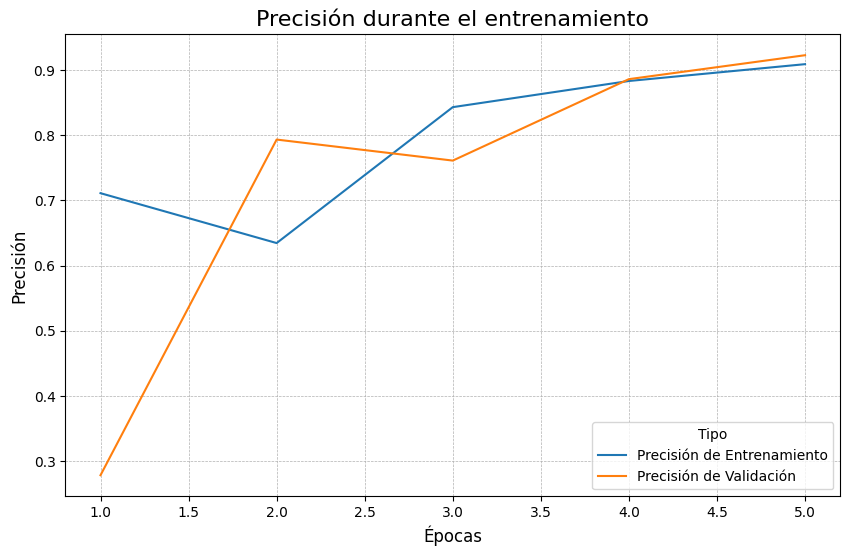

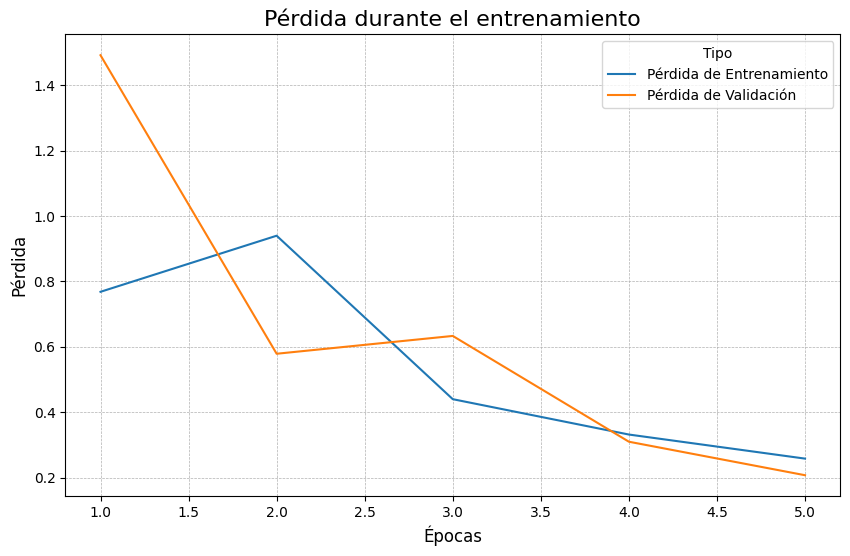

In [75]:
# Crear tablas de precisión y pérdida
def plot_metrics(history):
    # Crear un DataFrame con las métricas
    metrics_df = pd.DataFrame({
        'Época': range(1, len(history.history['accuracy']) + 1),
        'Precisión de Entrenamiento': history.history['accuracy'],
        'Precisión de Validación': history.history['val_accuracy'],
        'Pérdida de Entrenamiento': history.history['loss'],
        'Pérdida de Validación': history.history['val_loss']
    })

    # Plot de Precisión
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Época', y='value', hue='variable',
                 data=metrics_df.melt(id_vars=['Época'], value_vars=[
                     'Precisión de Entrenamiento', 'Precisión de Validación']))
    plt.title('Precisión durante el entrenamiento', fontsize=16)
    plt.xlabel('Épocas', fontsize=12)
    plt.ylabel('Precisión', fontsize=12)
    plt.legend(title='Tipo', loc='lower right')
    plt.grid(visible=True, linestyle='--', linewidth=0.5)
    plt.show()

    # Plot de Pérdida
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Época', y='value', hue='variable',
                 data=metrics_df.melt(id_vars=['Época'], value_vars=[
                     'Pérdida de Entrenamiento', 'Pérdida de Validación']))
    plt.title('Pérdida durante el entrenamiento', fontsize=16)
    plt.xlabel('Épocas', fontsize=12)
    plt.ylabel('Pérdida', fontsize=12)
    plt.legend(title='Tipo', loc='upper right')
    plt.grid(visible=True, linestyle='--', linewidth=0.5)
    plt.show()

# Llamar a la función para graficar
plot_metrics(history_rnn)


5.	Comparación y Conclusiones:

    -	Comparar los resultados obtenidos entre los modelos ANN, CNN y RNN en términos de precisión, tiempo de entrenamiento y capacidad de generalización.

    -	Evaluar si alguna de las arquitecturas proporciona una ventaja significativa en la clasificación de arritmias.

    -	Extraer conclusiones sobre cuál modelo es más adecuado para la clasificación de arritmias, proponiendo mejoras para experimentos futuros, como la implementación de técnicas de aumento de datos y el uso de arquitecturas avanzadas.
